In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from altaipony.flarelc import FlareLightCurve

from astropy.io import fits    


import os


flux_label = r"Flux [e$^{-}$/s]"
time_label = "Time [BJD]"

# load all the file names
files = np.loadtxt("files.txt", dtype=str)

In [321]:
# contain flares
files[8], files[10]
files[5], files[6]

('20240312075007', '20240529072301')

In [323]:
# GET THE DATA ---------------------------------------------------------------

# pick a file
file = files[10]

# load the detrended data
location = f"../data/hip67522/CHEOPS-products-{file}/Outdata/00000/{file}_detrended_lc.csv"
df = pd.read_csv(location)


# load the masked data points
mask_location = f"../data/hip67522/CHEOPS-products-{file}/Outdata/00000/{file}_mask.txt"

 
# FIND FLARES WITH ALTAIPONY ----------------------------------------------------

# define flare light curve
flc = FlareLightCurve(time = df.time, flux = df.flux, flux_err=np.std(df.flux))
flc.detrended_flux = df.flux
flc.detrended_flux_err = np.std(df.flux)

# find flares
flares = flc.find_flares(N1=3, N2=2, N3=3).flares


/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
Found 1 candidate(s) in the (0,1063) gap.
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


2460400.002611765


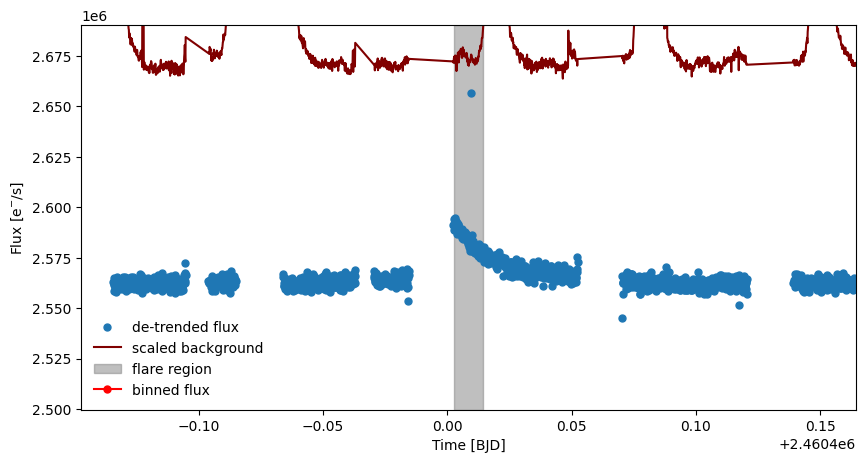

In [324]:
%matplotlib inline
# PLOT THE FLARE CANDIDATES ----------------------------------------------------------
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
      
    # how much to show around the flare
    window = 0.15

    # flare mask
    flare_m = (df.time > (row.tstart - window)) & (df.time < (row.tstop + window))

    # apply the mask
    tflare = df.time[flare_m].values
    fflare = df.flux[flare_m].values
    bgflare = df.bg[flare_m].values

    # calculate factor to scale the background
    rangetflare = np.max(fflare) - np.min(fflare)

    # scale the background
    bgflare = (bgflare - np.median(bgflare))*rangetflare/10 + np.median(df.flux) + rangetflare

    # plot the data
    plt.plot(tflare, fflare, ".", markersize=10, label="de-trended flux")
    plt.plot(tflare, bgflare, color="maroon", label="scaled background")

    # now bin the data to show in overlay
    binsize = 5

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    # bin the data
    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)


    # shade the region of the flare
    plt.axvspan(row.tstart, row.tstop, alpha=0.5, color="grey", label="flare region")
    
    # plot the binned data
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red", label="binned flux")

    # layout
    plt.xlabel(time_label)
    plt.ylabel(flux_label)
    plt.legend(frameon=False)
    plt.xlim(row.tstart - window, row.tstop + window)
    plt.ylim(np.median(fflare) - 10*np.std(fflare), np.median(fflare) + 20*np.std(fflare))

/tmp/ipykernel_4981/139001128.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240522113135/Outdata/00000/residuals_im.fits'>
  hdulist = fits.open(IMG)


Residuals image file found for 20240312075007:
 ../data/hip67522/CHEOPS-products-20240312075007/Outdata/00000/residuals_im.fits

Image shape: (3402, 60, 60)
Light curve shape: (1134, 10)


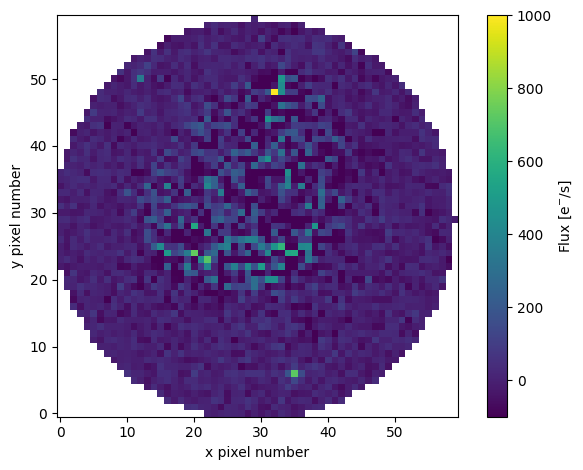

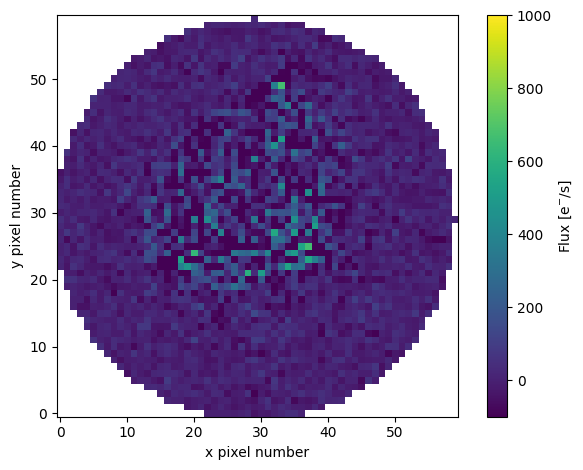

In [315]:
# SHOW RESIDUAL IMAGE ----------------------------------------------------------

# pick which flare to inspect by index
id = 0

IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/residuals_im.fits'
hdulist = fits.open(IMG)
print(f"Residuals image file found for {file}:\n {IMG}\n")

# read in mask
mask = np.loadtxt(mask_location, dtype=bool)

# get the image data
image_data = hdulist[0].data[mask]

print(f"Image shape: {image_data.shape}")
print(f"Light curve shape: {df.shape}") 

index = flares.iloc[id].istart 
index_end = flares.iloc[id].istop 
deltaindex = index_end - index

# sum over the first axis
image_data = image_data[index:index_end].sum(axis=0)

# show the image
plt.imshow(image_data, cmap="viridis", origin="lower", vmin=-100, vmax=1000)
plt.colorbar(label=r"Flux [e$^{-}$/s]")

plt.xlabel("x pixel number")
plt.ylabel("y pixel number")

plt.tight_layout()

# make another image 20 indices later
index += 40
index_end += 40
image_data = hdulist[0].data[mask][index:index_end].sum(axis=0)

plt.figure()
plt.imshow(image_data, cmap="viridis", origin="lower", vmin=-100, vmax=1000)
plt.colorbar(label=r"Flux [e$^{-}$/s]")
plt.xlabel("x pixel number")
plt.ylabel("y pixel number")

plt.tight_layout()

Residuals image file found for 20240410135336:
 ../data/hip67522/CHEOPS-products-20240410135336/Outdata/00000/residuals_im.fits

Image shape: (2465, 60, 60)
Light curve shape: (3189, 10)


/tmp/ipykernel_4981/2411980397.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240410135336/Outdata/00000/residuals_im.fits'>
  hdulist = fits.open(IMG)
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


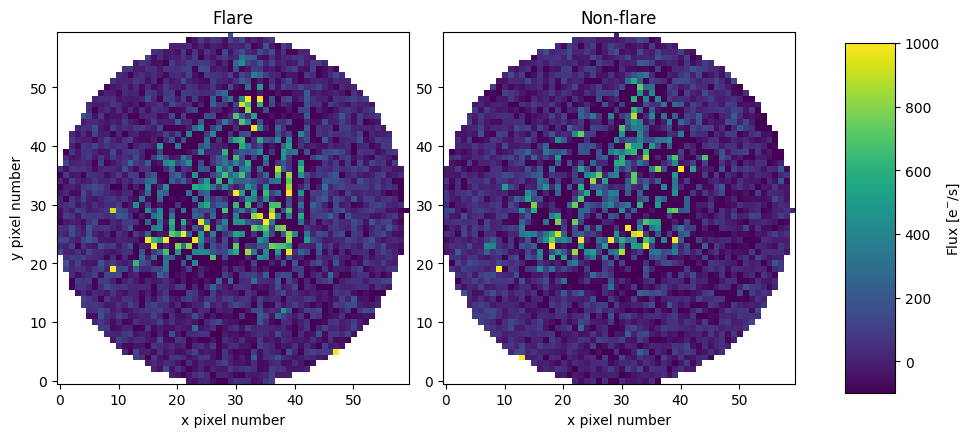

In [332]:
# rewrite the above cell but using a two panel plot

# pick which flare to inspect by index
id = 0

IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/residuals_im.fits'
hdulist = fits.open(IMG)
print(f"Residuals image file found for {file}:\n {IMG}\n")

# read in mask
mask = np.loadtxt(mask_location, dtype=bool)

# get the image data
image_data = hdulist[0].data[mask]

print(f"Image shape: {image_data.shape}")
print(f"Light curve shape: {df.shape}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

index = flares.iloc[id].istart
index_end = flares.iloc[id].istop
deltaindex = index_end - index

# sum over the first axis
image_data = image_data[index:index_end].sum(axis=0)

# show the image
ax[0].imshow(image_data, cmap="viridis", origin="lower", vmin=-100, vmax=1000)

ax[0].set_xlabel("x pixel number")
ax[0].set_ylabel("y pixel number")
ax[0].set_title("Flare")

# make another image 20 indices later
index += 40
index_end += 40
image_data = hdulist[0].data[mask][index:index_end].sum(axis=0)

im = ax[1].imshow(image_data, cmap="viridis", origin="lower", vmin=-100, vmax=1000)

ax[1].set_xlabel("x pixel number")
ax[1].set_title("Non-flare")

plt.tight_layout()

# add a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label=r"Flux [e$^{-}$/s]")


In [70]:
true_flares_index = []

# for each true flare put a 1 in the flare table
flares["true_flares"] = 0

# change the value of the true flare to 1
flares.loc[true_flares_index, "true_flares"] = 1

flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,true_flares
0,572,575,NaN,NaN,2.460457e+06,2.460457e+06,0.111189,0.015399,0.004304,0.000348,3039.0,0
1,2789,2794,NaN,NaN,2.460458e+06,2.460458e+06,0.418243,0.041872,0.005412,0.001276,3039.0,0


In [71]:

# write flare data to file

# if ../results/{file} does not exist, create it
if not os.path.exists(f"../results/{file}"):
    os.makedirs(f"../results/{file}")

flares.to_csv(f"../results/{file}/flare_candidates.csv", index=False)